<h1 style="text-align: center; color: orange"> Calculate effective target length based on beam position offset on cyro cell </h1>

In [1]:
import sys
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from common_functions import rs, fmts, shaxes


def eff_targ_length(xr=1.0,yr=1.0,xoff=0.0,yoff=0.0,n_samples=1000000):
    """
    Estimate the effective liquid target length seen by the beam for a cylindrical cryotarget, given raster size and beam offsets.
    This function is a Python rewrite of the original ROOT/C++ function `effTargL`
    https://hallcweb.jlab.org/elogs/E12-10-002+Preparations/365

    Parameters
    ----------
    xr : Half-width of the raster in x (in mm). The beam is sampled uniformly in the range [-xr, +xr] around xoff.
    yr : Half-width of the raster in y (in mm). The beam is sampled uniformly in the range [-yr, +yr] around yoff.
    xoff : Horizontal (x) offset of the beam from the target center (mm).
    yoff : Vertical (y) offset of the beam from the target center (mm).
    n_samples : Number of Monte Carlo samples used to estimate the effective length.

    Returns
    -------
    float
        The mean multiplicative correction factor:
            mean( L_effective / L_nominal )
        where L_nominal is the nominal target length (including shrinkage).
    """

    # -------------------------------------------------------------------------
    # 1. Target geometry (in mm)
    # -------------------------------------------------------------------------
    # Nominal target length in mm, multiplied by a shrinkage factor (0.996) to account for thermal contraction of the cryogenic target.
    target_length = 99.98 * 0.996  # mm
    target_radius = 33.4  # mm

    # -------------------------------------------------------------------------
    # 2. Random number generator setup
    # -------------------------------------------------------------------------
    rng = np.random.default_rng()

    # -------------------------------------------------------------------------
    # 3. Sample beam positions (x, y) with raster and offsets
    # -------------------------------------------------------------------------
    u_x = rng.random(n_samples)
    u_y = rng.random(n_samples)

    x = (2.0 * (u_x - 0.5)) * xr + xoff
    y = (2.0 * (u_y - 0.5)) * yr + yoff

    # Distance from target center in the transverse plane, r = sqrt(x^2 + y^2).
    # This is useful for diagnostics but not strictly required for the correction.
    r_sq = x**2 + y**2
    r = np.sqrt(r_sq)

    # -------------------------------------------------------------------------
    # 4. Compute effective path length through the cylindrical target
    # -------------------------------------------------------------------------
    # Geometry:
    # For a cylinder of radius R, a beam line displaced by (x, y) from the
    # center will traverse a shorter effective length than a central beam.
    #
    # The original C++ code used:
    #   effL = targetL - (targetR - sqrt(targetR^2 - x^2 - y^2));
    #
    # This effectively subtracts the amount the beam "misses" near the ends
    # of the target due to being off-center. The sqrt(...) term corresponds
    # to the allowed transverse distance within the cylinder.
    #
    # Note: For realistic raster sizes (e.g. 1 mm) compared to the radius
    # (~33 mm), x^2 + y^2 << targetR^2 and the sqrt is always real.
    # Still, we protect against numerical issues by masking unphysical points.
    inside_mask = r_sq <= target_radius**2

    # Compute the square root only for points inside the cylinder.
    # Points outside the radius are unphysical for a cylindrical cryotarget;
    # for safety, we set their effective length to 0 (they contribute nothing).
    eff_length = np.zeros_like(x)

    # Only compute where the ray is inside the target radius
    sqrt_term = np.zeros_like(x)
    sqrt_term[inside_mask] = np.sqrt(target_radius**2 - r_sq[inside_mask])

    eff_length[inside_mask] = target_length - (target_radius - sqrt_term[inside_mask])

    # -------------------------------------------------------------------------
    # 5. Compute multiplicative correction factor
    # -------------------------------------------------------------------------
    # The correction factor is defined as:
    #   f = effL / targetL
    # and we are interested in the *mean* of this over all sampled (x,y).
    with np.errstate(invalid = "ignore"):
        correction_factors = eff_length / target_length

    # Mean over all valid samples. Since eff_length is 0 for any unphysical samples (if any existed), those would drive the average down, but with
    # reasonable raster parameters this should not occur.
    mean_correction = np.mean(correction_factors)

    return mean_correction

In [ ]:
def scan_offsets(xr = 1.0, yr = 1.0, xoff_max = 6.0, step = 0.5, n_samples = 1000000):
    """
    Scan beam offsets in x from 0 to xoff_max (mm) and compute the effective target length correction factor at each offset.

    This function is a Python rewrite of the original ROOT/C++ function `effTargL`
    https://hallcweb.jlab.org/elogs/E12-10-002+Preparations/365

    Returns
    -------
    offsets : Array of x-offsets (mm) at which the correction was evaluated.
    corrections : Corresponding array of mean multiplicative correction factors.
    """

    # Create an array of offsets like 0, 0.5, 1.0, ..., xoff_max
    offsets = np.arange(0.0, xoff_max + step / 2.0, step)

    corrections = []

    # Loop over each x-offset and compute the effective correction
    for xoff in offsets:
        corr = eff_targ_length(xr = xr, yr = yr, xoff = xoff, yoff = 0.0, n_samples = n_samples)
        corrections.append(corr)

    corrections = np.array(corrections)

    return offsets, corrections

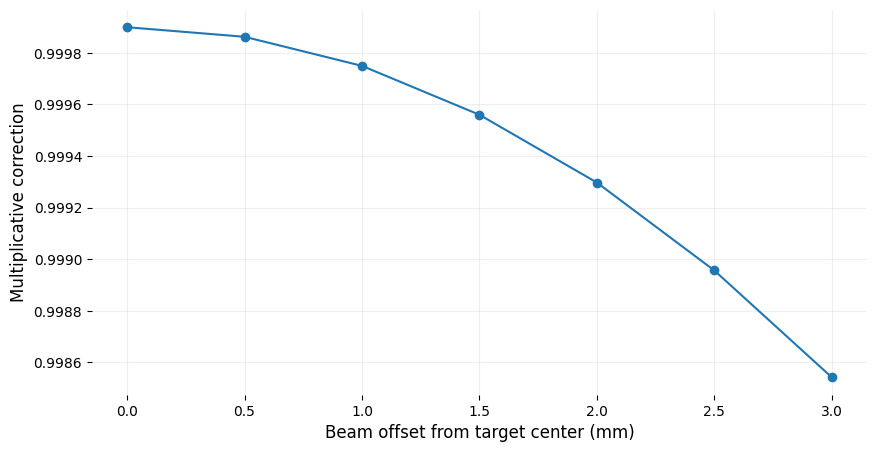

In [3]:
offsets_mm, corr_factors = scan_offsets(xr = 1.0, yr = 1.0, xoff_max = 3.0, step = 0.5, n_samples = 200_000)

# Simple plot of correction vs beam offset
fig, ax = shaxes(xlabel = 'Beam offset from target center (mm)', ylabel = 'Multiplicative correction')
ax.plot(offsets_mm, corr_factors, marker = fmts[0])